In [210]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

In [82]:
openGraphs = False

In [135]:
def GLabels(shape):
    if (type(shape) != tuple):
        raise TypeError("shape passed to GLabels wasn't right")
    out = []
    for j in range(shape[1]):
        for i in range(shape[0]):
            out = out + [((i, j), "a")] + [((i, j), "b")]
    return out

def GLabelToR(label):
    if (type(label) != tuple):
        raise TypeError("label passed to GLabelToR wasn't right")
    if (type(label[0]) != tuple):
        raise TypeError("position passed to GLabelToR wasn't right")
    
    a1 = np.array([1, 0])
    a2 = np.array([1/2, np.sqrt(3)/2])
    T1 = np.array([0, 1/np.sqrt(3)])
    
    return label[0][0] * a1 + label[0][1] * a2 + T1 * (label[1] == "b")
    
def GLabelToIndex(label, shape):
    if (type(label) != tuple):
        raise TypeError("label passed to GLabelToIndex wasn't right")
    if (type(label[0]) != tuple):
        raise TypeError("position passed to GLabelToIndex wasn't right")
    
    offset = 0
    if (label[1] == "b"):
        offset = 1
    return 2 * label[0][0] + shape[0] * label[0][1] * 2 + offset

def GMomentumLabels(shape):
    if (type(shape) != tuple):
        raise TypeError("shape passed to GMomentumLabels wasn't right")
    
    out = []
    for j in range(shape[1]):
        for i in range(shape[0]):
            out = out + [((i, j), "a")] + [((i, j), "b")]
    return out   

def GMomentumLabelToK(label, shape):
    if (type(shape) != tuple):
        raise TypeError("shape passed to GMomentumLabelToK wasn't right")
    b1 = np.array([1, -1/np.sqrt(3)]) * 2 * np.pi / shape[0]
    b2 = np.array([0, 2/np.sqrt(3)]) * 2 * np.pi / shape[1]
    
    return label[0][0] * b1 + label[0][1] * b2 
    
def IsGrapheneNeighbor(labela, labelb, shape):
    if (labela == labelb):
        return False
    if (labela[1] == labelb[1]):
        return False
    if (labela[1] == "a"):
        apos = labela[0]
        bpos = labelb[0]
    if (labelb[1] == "a"):
        apos = labelb[0]
        bpos = labela[0]
    modx = shape[0] # x direction to mod by
    mody = shape[1] # y direction to mod by
    ax = apos[0]
    ay = apos[1]
    bx = bpos[0]
    by = bpos[1]
    if (ax - bx == 0 and (ay - by) % mody == 0): # when b is right above a (same cell)
        return True # works, turn back on
    if ((ay - 1) % mody == by and ax == bx): # when b is lower left of a
        return True
    if ((bx - 1) % modx == ax and (ay - 1) % mody == by): # when b is lower right of a
        return True
    return False
    
def GrapheneHamiltonian(shape):
    glabels= GLabels(shape)
    out = np.zeros((len(glabels), len(glabels)))
    for i in range(len(glabels)):
        for j in range(len(glabels)):
            if (IsGrapheneNeighbor(glabels[i], glabels[j], shape)):
                out[i, j] = -1
    return out

def GrapheneTransform(shape):
    glabels = GLabels(shape)
    klabels = GMomentumLabels(shape)
    out = np.zeros((len(glabels), len(glabels)), dtype=complex)
    r_vec = np.array([GLabelToR(glabels[i]) for i in range(len(glabels))])
    k_vec = np.array([GMomentumLabelToK(klabels[i], shape) for i in range(len(klabels))])
    out = r_vec @ k_vec.T
    print(out.shape)
    deltas = np.indices((len(glabels), len(glabels))).sum(axis=0) % 2 * -1 + 1
    return np.asmatrix((1/np.sqrt(shape[0] * shape[1]))*np.exp(1.j*out) * deltas)

((2, 3), 'b')


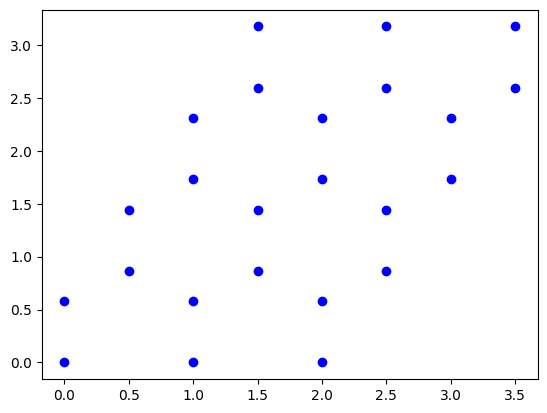

In [138]:
glabels = GLabels((3, 4))
glocations = [GLabelToR(i) for i in glabels]
for i in glocations:
    plt.scatter(i[0], i[1], c="blue")
# print(glabels)
print(glabels[GLabelToIndex(((2, 3), "b"), (3, 4))])

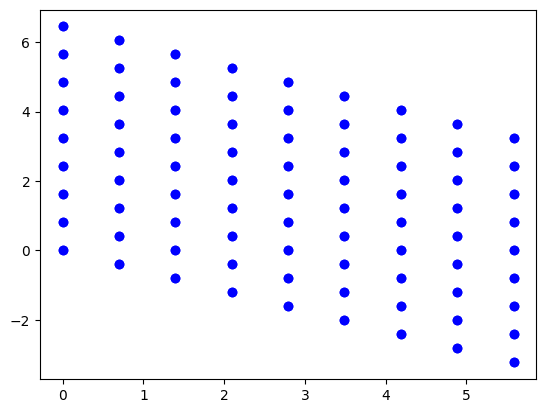

In [7]:
gklabels = GMomentumLabels((9, 9))
gklocations = [GMomentumLabelToK(i, (9, 9)) for i in gklabels]
for i in gklocations:
    plt.scatter(i[0], i[1], c="blue")
# print(gklabels[])

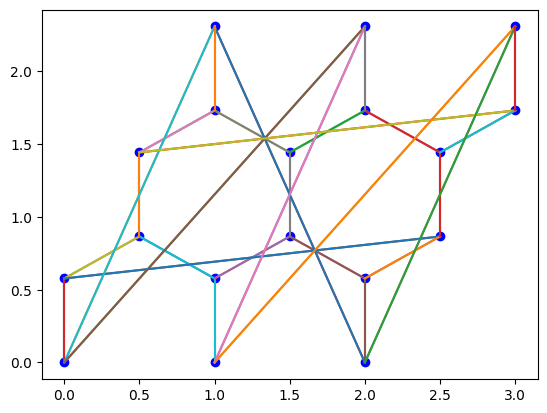

In [141]:
glabels = GLabels((3, 3))
for l in glabels:
    for m in glabels:
        if (IsGrapheneNeighbor(l, m, (3, 3))):
            a = GLabelToR(l)
            b = GLabelToR(m)
            plt.plot([a[0], b[0]], [a[1], b[1]])
        
    i = GLabelToR(l)
    plt.scatter(i[0], i[1], c="blue")

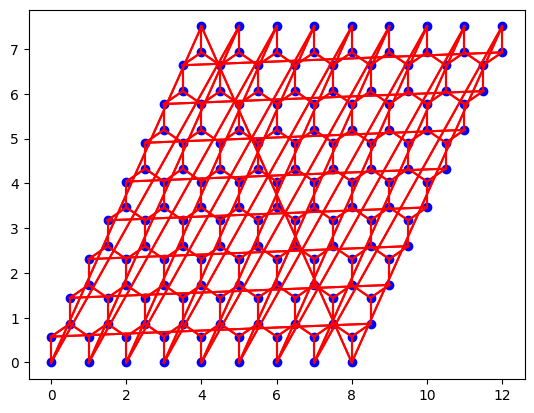

In [9]:
glabels9 = GLabels((9, 9))
for l in glabels9:
    for m in glabels9:
        if (IsGrapheneNeighbor(l, m, (9, 9))):
            a = GLabelToR(l)
            b = GLabelToR(m)
            plt.plot([a[0], b[0]], [a[1], b[1]], c="red")
        
    i = GLabelToR(l)
    plt.scatter(i[0], i[1], c="blue")

(1458, 1458)


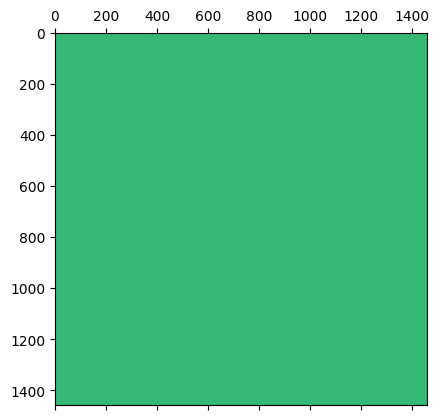

In [49]:
shape = (27, 27)
H = GrapheneHamiltonian(shape)
F = GrapheneTransform(shape)
Hk = F.H @ H @ F
plt.matshow(Hk.real)

In [50]:
Es = []
kx = []
ky = []
gklabels = GMomentumLabels(shape)
gaps = []
for i in range(shape[0] * shape[1]):
    bb1, bb2 = 2*i, 2*i + 2
    block = Hk[bb1:bb2, bb1:bb2]
    eigs, vecs = np.linalg.eigh(block)
    gap = abs(eigs[0] - eigs[1])
    gaps.append(gap)
    for eig in eigs:
        Es.append(eig)
    # out = GMomentumLabelToK(gklabels[i], shape)
    # kx = kx + [out[0]]
    # ky = ky + [out[1]]
ks = np.array([GMomentumLabelToK(gklabels[i], shape) for i in range(2 *shape[0] * shape[1])])
kx = [k[0] for k in ks]
ky = [k[1] for k in ks]
pEs = [E for E in Es if E > 0]
nEs = [E for E in Es if E < 0]
print(pEs)
print(kx)

[2.999999999999997, 2.9819757682314076, 2.9282299365476154, 2.83974959679122, 2.71820425406391, 2.5659928028263503, 2.386334576430497, 2.18344239318515, 1.9628517695321872, 1.7320508075688767, 1.5016768788674428, 1.287652419851046, 1.1141048051491234, 1.0134330609528328, 1.0134330609528324, 1.1141048051491234, 1.2876524198510455, 1.5016768788674428, 1.7320508075688765, 1.9628517695321879, 2.18344239318515, 2.3863345764304973, 2.5659928028263495, 2.71820425406391, 2.839749596791222, 2.928229936547615, 2.9819757682314076, 2.9819757682314108, 2.9819757682314085, 2.946089741159646, 2.874968505574353, 2.769927040700382, 2.6329767292255997, 2.466889869566905, 2.275323370132816, 2.063054438912486, 1.8364322137605473, 1.6042463855100872, 1.3793588520020117, 1.1814096989452718, 1.0393400714414627, 0.9864767154838857, 1.039340071441463, 1.1814096989452718, 1.3793588520020112, 1.6042463855100872, 1.8364322137605475, 2.063054438912486, 2.2753233701328157, 2.4668898695669053, 2.6329767292255988, 2.

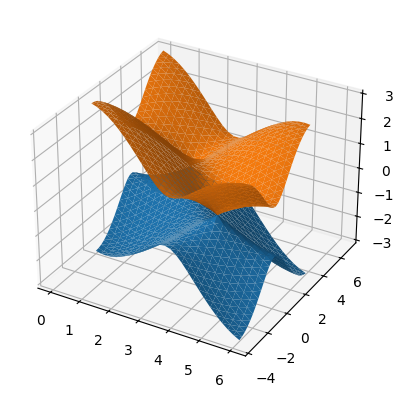

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx[::2],ky[::2],Es[::2])
ax.plot_trisurf(kx[1::2],ky[1::2],Es[1::2])
# ax.plot_trisurf(kx,ky,Es)
# ax.plot_trisurf(kx,ky,nEs)
# ax.view_init(-1, 30)

Text(0, 0.5, 'ky')

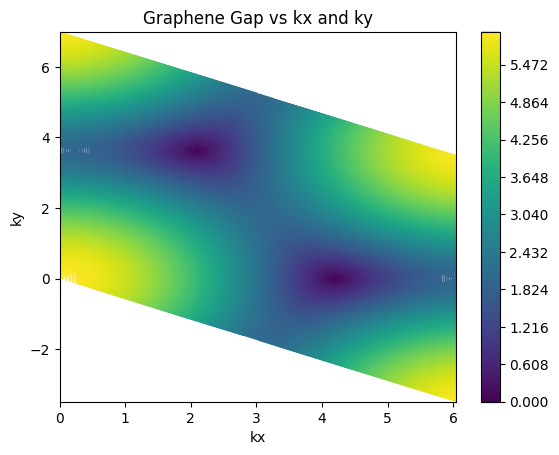

In [52]:
plt.tricontour(kx[::2], ky[::2], gaps, levels=998)
plt.colorbar()
plt.title("Graphene Gap vs kx and ky")
plt.xlabel("kx")
plt.ylabel("ky")

[4.1887902047863905, 2.0943951023931953]
[36, 37, 90, 91, 144, 145, 198, 199, 252, 253, 306, 307, 360, 361, 414, 415, 468, 469, 522, 523, 576, 577, 630, 631, 684, 685, 738, 739, 792, 793, 846, 847, 900, 901, 954, 955, 1008, 1009, 1062, 1063, 1116, 1117, 1170, 1171, 1224, 1225, 1278, 1279, 1332, 1333, 1386, 1387, 1440, 1441]


Text(0, 0.5, 'E')

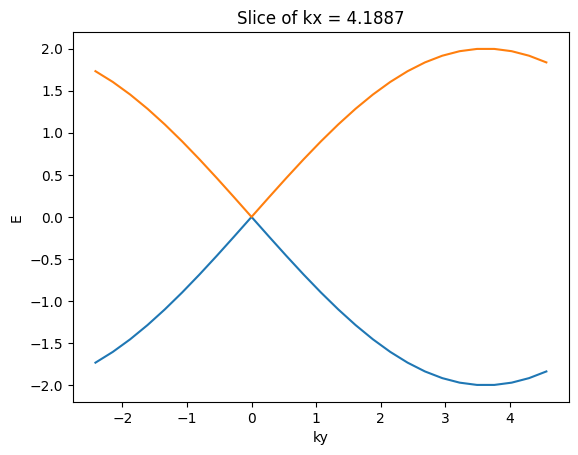

In [53]:
where0 = []
for i in range(0, len(Es), 2):
    if (abs(Es[i] - Es[i+1]) < 0.00001):
        where0.append(kx[i])
print(where0)
idxs = []
for i in range(len(Es)):
    if kx[i] == where0[0]:
        idxs.append(i)
print(idxs)
sys = [ky[i] for i in range(len(ky)) if i in idxs]
sEs = [Es[i] for i in range(len(ky)) if i in idxs]
plt.plot(sys[::2], sEs[::2])
plt.plot(sys[1::2], sEs[1::2])
plt.title("Slice of kx = 4.1887")
plt.xlabel("ky")
plt.ylabel("E")

In [54]:
thing = go.Mesh3d(x=kx[::2],y=ky[::2],z=Es[::2])
# fig = go.Figure(data=thing)
fig = go.Figure(data=[thing, go.Mesh3d(x=kx[1::2], y=ky[1::2], z=Es[1::2])])
# fig = px.scatter_3d(x=kx, y=ky, z=nEs)
fig.write_html('Graphene.html', auto_open=openGraphs)

# Boron Nitride

In [55]:
def BoronNitrideHamiltonian(shape, M):
    glabels= GLabels(shape)
    out = np.zeros((len(glabels), len(glabels)))
    for i in range(len(glabels)):
        for j in range(len(glabels)):
            if (IsGrapheneNeighbor(glabels[i], glabels[j], shape)):
                out[i, j] = -1
            if (i == j):
                if glabels[i][1] == "a":
                    out[i, i] = M
                if glabels[i][1] =="b":
                    out[i, i] = -M
    return out

# def BoronNitrideTransform(shape):
#     glabels = GLabels(shape)
#     klabels = GMomentumLabels(shape)
#     out = np.zeros((len(glabels), len(glabels)), dtype=complex)
#     r_vec = np.array([GLabelToR(glabels[i]) for i in range(len(glabels))])
#     k_vec = np.array([GMomentumLabelToK(klabels[i], shape) for i in range(len(klabels))])
#     out = r_vec @ k_vec.T
#     print(out.shape)
#     deltas = np.indices((len(glabels), len(glabels))).sum(axis=0) % 2 * -1 + 1
#     return np.asmatrix((1/np.sqrt(shape[0] * shape[1]))*np.exp(1.j*out) * deltas)

(1458, 1458)


Text(0.5, 1.0, 'Matshow of H_k')

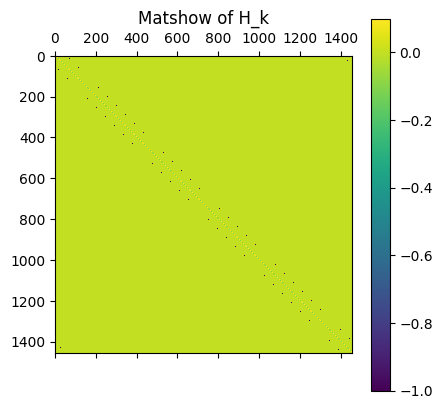

In [189]:
shape = (27, 27)
H = BoronNitrideHamiltonian(shape, 0.1)
F = GrapheneTransform(shape)
Hk = F.H @ H @ F
plt.matshow(H.real)
plt.colorbar()
plt.title("Matshow of H_k")

In [190]:
Es = []
gaps = []
for i in range(shape[0] * shape[1]):
    bb1, bb2 = 2*i, 2*i + 2
    block = Hk[bb1:bb2, bb1:bb2]
    eigs, vecs = np.linalg.eigh(block)
    for eig in eigs:
        Es.append(eig)
    gap = abs(eigs[0] - eigs[1])
    gaps.append(gap)
ks = np.array([GMomentumLabelToK(gklabels[i], shape) for i in range(2 *shape[0] * shape[1])])
kx = [k[0] for k in ks]
ky = [k[1] for k in ks]
print(len(kx))
print(len(Es))


1458
1458


In [191]:
thing = go.Mesh3d(x=kx[::2],y=ky[::2],z=Es[::2])
thing2 = go.Mesh3d(x=kx[1::2], y=ky[1::2], z=Es[1::2])
# fig = go.Figure(data=thing)
fig = go.Figure(data=[thing, thing2])
# fig = px.scatter_3d(x=kx, y=ky, z=nEs)
fig.write_html('BoronNitride.html', auto_open=openGraphs)

Text(0.5, 0.92, 'Energy of Boron Nitride')

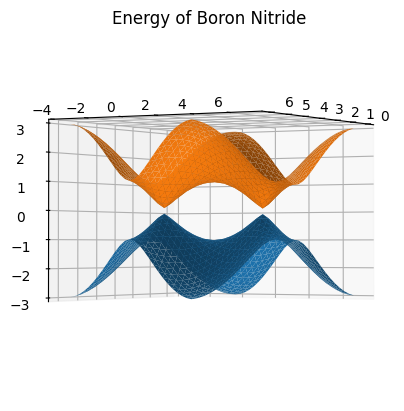

In [192]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx[::2],ky[::2],Es[::2])
ax.plot_trisurf(kx[1::2],ky[1::2],Es[1::2])
ax.view_init(-1, 30)
plt.title("Energy of Boron Nitride")

Text(0, 0.5, 'ky')

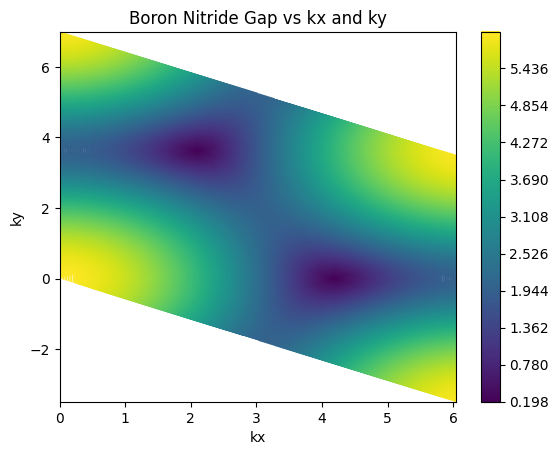

In [193]:
plt.tricontour(kx[::2], ky[::2], gaps, levels=998)
plt.colorbar()
plt.title("Boron Nitride Gap vs kx and ky")
plt.xlabel("kx")
plt.ylabel("ky")

# Haldane 

In [195]:
def HaldaneInteraction(label1, label2, shape, t=0.3, phi=0.7, test = False):
    if (label1 == label2):
        # print("returned because same point")
        return 0
    if (label1[1] != label2[1]):
        # print("returned because different letters")
        return 0
    apos = label1[0]
    bpos = label2[0]
    
    N1, N2 = shape
    i0, j0 = apos
    iup = (i0 + 1) % N1
    idown = (i0 - 1) % N1
    jup = (j0 + 1) % N2
    jdown = (j0 - 1) % N2
    
    p1 = (iup, j0)
    p2 = (i0, jdown)
    p3 = (idown, jup)
    p4 = (iup, jdown)
    p5 = (idown, j0)
    p6 = (i0, jup)
    
    ptsout = [p1, p2, p3]
    ptsin = [p4, p5, p6]
    # print(bpos)
    # print(ptsout)
    # print(ptsin)
    if (bpos in ptsout):
        if (test):
            return 1
        return -t * np.exp(1.j * phi)
    if (bpos in ptsin):
        if (test):
            return -1
        return -t * np.exp(-1.j * phi)
    # print("returned because made it to end")
    return 0
    
    

def HaldaneHamiltonian(shape, t=0.3, phi=0.7, M=0.1):
    # Build everything except the arrows
    glabels= GLabels(shape)
    out = np.zeros((len(glabels), len(glabels)))
    for i in range(len(glabels)):
        for j in range(len(glabels)):
            out[i, j] = HaldaneInteraction(glabels[i], glabels[j], shape, t, phi)
            if (IsGrapheneNeighbor(glabels[i], glabels[j], shape)):
                out[i, j] = -1
            if (i == j):
                if glabels[i][1] == "a":
                    out[i, i] = M
                if glabels[i][1] =="b":
                    out[i, i] = -M
            
            
            
    
    # Build the arrows
    
    
    return np.asmatrix(out)

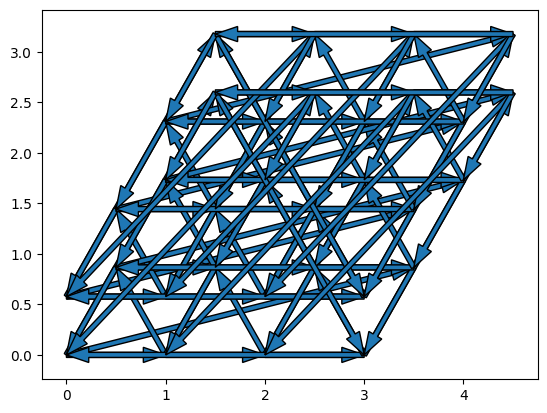

In [200]:
glabels = GLabels((4, 4))
for i in glabels:
    i = GLabelToR(l)
    plt.scatter(i[0], i[1], c="blue")
for l in glabels:
    for m in glabels:
        # if (IsGrapheneNeighbor(l, m, (3, 3))):
        #     a = GLabelToR(l)
        #     b = GLabelToR(m)
        #     plt.plot([a[0], b[0]], [a[1], b[1]], c="green")
        if (HaldaneInteraction(l, m, (4, 4), test=True) > 0):
            a = GLabelToR(l)
            b = GLabelToR(m)
            plt.arrow(a[0], a[1], b[0]-a[0], b[1]-a[1], width = 0.05, length_includes_head=True)
            # plt.plot([a[0], b[0]], [a[1], b[1]], c="red")
        # if (HaldaneInteraction(l, m, (3, 3), test=True) > 0):
        #     a = GLabelToR(l)
        #     b = GLabelToR(m)
        #     plt.arrow(a[0], a[1], b[0]-a[0], b[1]-a[1], width = 0.01, length_includes_head=True)
        
    

C:\Users\ajwef\AppData\Local\Temp\ipykernel_22328\1248418438.py:49: ComplexWarning:

Casting complex values to real discards the imaginary part



are we hermitian? True
(1458, 1458)


Text(0.5, 1.0, 'Matshow of H_k (Haldane)')

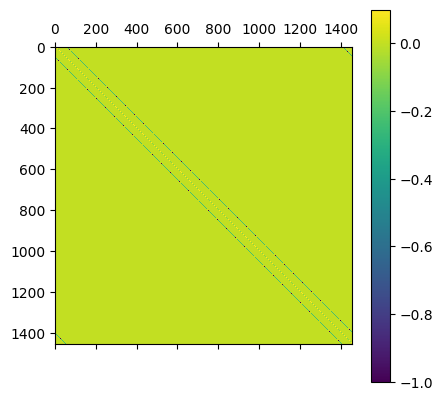

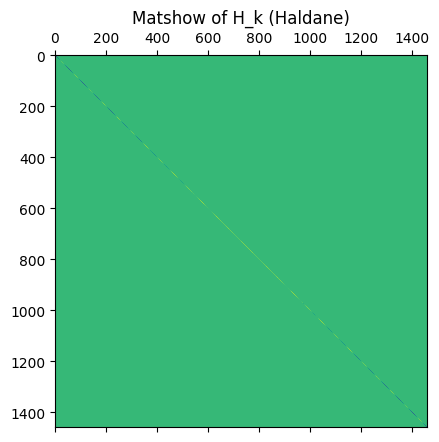

In [224]:

shape = (27, 27)
H = HaldaneHamiltonian(shape, M=0.1)
plt.matshow(H.real)
plt.colorbar()
print(f"are we hermitian? {np.allclose(H.H, H)}")
F = GrapheneTransform(shape)
Hk = F.H @ H @ F
plt.matshow(Hk.real)

plt.title("Matshow of H_k (Haldane)")

In [225]:
Es = []
gaps = []
for i in range(shape[0] * shape[1]):
    bb1, bb2 = 2*i, 2*i + 2
    block = Hk[bb1:bb2, bb1:bb2]
    eigs, vecs = np.linalg.eigh(block)
    for eig in eigs:
        Es.append(eig)
    gap = abs(eigs[0] - eigs[1])
    gaps.append(gap)
ks = np.array([GMomentumLabelToK(gklabels[i], shape) for i in range(2 *shape[0] * shape[1])])
kx = [k[0] for k in ks]
ky = [k[1] for k in ks]
print(len(kx))
print(len(Es))

1458
1458


Text(0.5, 0.92, 'Energy of Haldane')

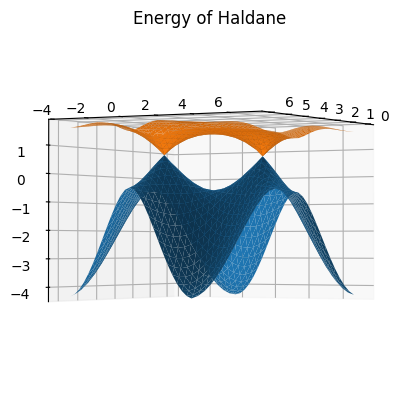

In [229]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx[::2],ky[::2],Es[::2])
ax.plot_trisurf(kx[1::2],ky[1::2],Es[1::2])
ax.view_init(-1, 30)
plt.title("Energy of Haldane")

In [208]:
thing = go.Mesh3d(x=kx[::2],y=ky[::2],z=Es[::2])
thing2 = go.Mesh3d(x=kx[1::2], y=ky[1::2], z=Es[1::2])
# fig = go.Figure(data=thing)
fig = go.Figure(data=[thing, thing2])
# fig = px.scatter_3d(x=kx, y=ky, z=nEs)
fig.write_html('Haldane.html', auto_open=openGraphs)

Text(0, 0.5, 'ky')

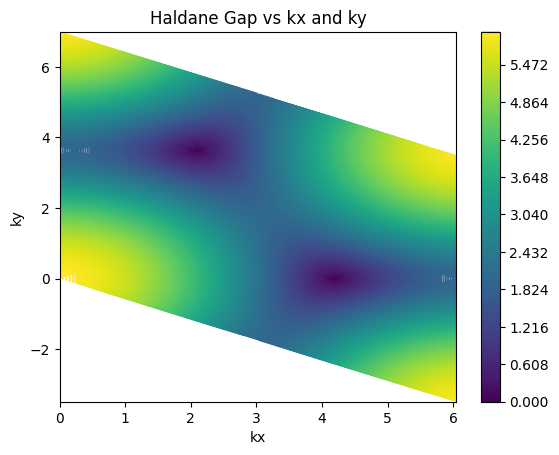

In [223]:
plt.tricontour(kx[::2], ky[::2], gaps, levels=998)
plt.colorbar()
plt.title("Haldane Gap vs kx and ky")
plt.xlabel("kx")
plt.ylabel("ky")

In [236]:
mingaps = []
for m in tqdm(range(10)):
    M = m/5
    print(f"M equals {M}")
    shape = (27, 27)
    H = HaldaneHamiltonian(shape, M=M)
    F = GrapheneTransform(shape)
    Hk = F.H @ H @ F
    Es = []
    gaps = []
    for i in range(shape[0] * shape[1]):
        bb1, bb2 = 2*i, 2*i + 2
        block = Hk[bb1:bb2, bb1:bb2]
        eigs, vecs = np.linalg.eigh(block)
        for eig in eigs:
            Es.append(eig)
        gap = abs(eigs[0] - eigs[1])
        gaps.append(gap)
    # print(gaps)
    ks = np.array([GMomentumLabelToK(gklabels[i], shape) for i in range(2 *shape[0] * shape[1])])
    kx = [k[0] for k in ks]
    ky = [k[1] for k in ks]
    gaps = [np.abs(Es[::2][i] - Es[1::2][i]) for i in range(int(len(Es)/2))]
    # minE = Es[np.argmin(Es[::2])]
    # maxE = Es[np.argmax(Es[1::2])]
    mingaps.append(np.min(gaps))
    


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ajwef\AppData\Local\Temp\ipykernel_22328\1248418438.py:49: ComplexWarning:

Casting complex values to real discards the imaginary part



M equals 0.0
(1458, 1458)


 10%|█         | 1/10 [00:01<00:17,  1.89s/it]

M equals 0.2
(1458, 1458)


 20%|██        | 2/10 [00:03<00:14,  1.84s/it]

M equals 0.4
(1458, 1458)


 30%|███       | 3/10 [00:05<00:13,  1.87s/it]

M equals 0.6
(1458, 1458)


 40%|████      | 4/10 [00:07<00:11,  1.92s/it]

M equals 0.8
(1458, 1458)


 50%|█████     | 5/10 [00:09<00:09,  1.86s/it]

M equals 1.0
(1458, 1458)


 60%|██████    | 6/10 [00:11<00:07,  1.87s/it]

M equals 1.2
(1458, 1458)


 70%|███████   | 7/10 [00:13<00:05,  1.91s/it]

M equals 1.4
(1458, 1458)


 80%|████████  | 8/10 [00:15<00:03,  1.98s/it]

M equals 1.6
(1458, 1458)


 90%|█████████ | 9/10 [00:17<00:01,  1.98s/it]

M equals 1.8
(1458, 1458)


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


In [238]:
print(mingaps)

[3.3306690738754696e-16, 0.39999999999999997, 0.8, 1.1999999999999997, 1.6000000000000003, 1.9999999999999984, 2.399999999999998, 2.7999999999999985, 3.1999999999999984, 3.5999999999999988]


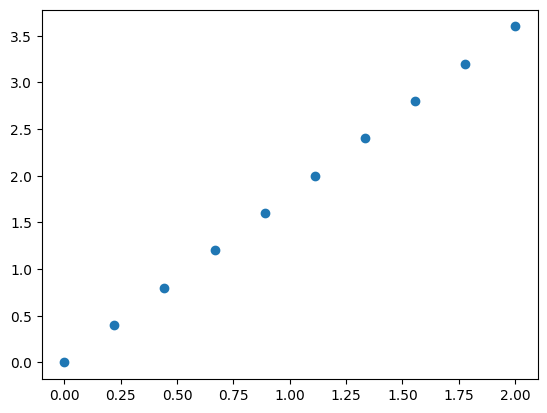

In [237]:
plt.scatter(np.linspace(0, 2, 10), mingaps)